# Tests per agegroup
Data extracted from weekly report of RIVM

In [1]:
import os
import numpy as np
import pandas as pd
import tabula
import requests
from bs4 import BeautifulSoup
import PyPDF2
import re
from tqdm.notebook import tqdm
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
from matplotlib import rcParams
rcParams['figure.figsize'] = 20,10

rivm_url = 'https://www.rivm.nl/coronavirus-covid-19/actueel/wekelijkse-update-epidemiologische-situatie-covid-19-in-nederland'
response = requests.get(rivm_url)
rivm_pdf_data_loc = './pdfs/'

In [2]:
url = []
href = []
period = []
name = []
datetime = []
week = []
filename = []

def columns(l):
    def ll(l):
        return -l.count('')
    
    if 'http' in l:
        l = l[ll(l) + 20:]
    
    href.append(l)
    period.append(pd.Period(l[ll(l) + 22 : ll(l) + 29],"M"))
    name.append(l[ll(l) + 65 : -4])
    datetime.append(pd.to_datetime(l[ll(l) + 65 : ll(l) + 73], format="%Y%m%d"))
    filename.append(l[ll(l) + 65:])
    url.append('https://www.rivm.nl'+l)

In [3]:
soup = BeautifulSoup(response.text, 'html.parser') 
aa = soup.find_all('a')
for a in aa:
    link = a.get('href')
    if link == None:
        pass
    elif link.endswith('.pdf'):
        columns(link)

pdfs = pd.DataFrame([period, datetime, week, name, filename, href, url]).T
pdfs = pdfs.rename(columns={0:'period',1:'date',2:'week',3:'name',4:'filename',5:'href',6:'url'})
pdfs['week'] = pdfs.date.dt.isocalendar().week
pdfs.sort_values(by='period', inplace=True)

In [4]:
def extract_tabel(pdf,date):
    
    def check_tabel(value):
        for key in checks:
            if checks[key]:
                pass
            elif isinstance(value,str) and key in value:
                checks[key] = True
    
    def create_agegroup_tabel(tabel, n):
        #print(tabel)
        if checks['Leeftijdsgroep'] and checks['fgelopen']:
            category = 'Leeftijd'
        elif checks['Groep'] and checks['fgelopen'] and checks['Kinderen']:
            category = 'Groep'
        elif checks['Groep'] and checks['Kinderen']:
            category = 'Groep'
        elif checks['Leeftijdsgroep']:
            category = 'Leeftijd'
            n+=1
        else:
            category = ''
        #print(checks)
        #print(category)
        csv = pdf[:-4]+'-'+category+'.csv'
        
        if category != '':
            #tabel.dropna(inplace=True)
            if not tabel.empty:
                #print('cat='+category)
                first_column = tabel.columns[0]
                agegroup_tabel = tabel.loc[(tabel[first_column].str.count('-') > 0)]                
                if category.startswith('Leeftijd'):
                    agegroup_tabel = agegroup_tabel.append(tabel.loc[(tabel[first_column].str.find('+') > 0)])
                    if len(tabel.columns) > 1:
                        second_column = tabel.columns[1]
                    else:
                        second_column = 'second_column'
                    agegroup_tabel.rename(columns={first_column:'Leeftijdsgroep',second_column:date}, inplace=True)
                elif category == 'Groep':
                    agegroup_tabel = agegroup_tabel.append(tabel.loc[(tabel[first_column].str.count('fgelopen') > 0)])
                    agegroup_tabel = agegroup_tabel.append(tabel.loc[(tabel[first_column].str.count('Groep') > 0)])
                agegroup_tabel = agegroup_tabel.sort_index()
                agegroup_tabel['Date'] = date
                agegroup_tabel.to_csv(csv, index=False)
                #print('CSV CREATED')
                #print(agegroup_tabel)
                return True
    
    #print('extracting '+pdf)
    #print(pdf)
    found_pages = []
    object = PyPDF2.PdfFileReader(pdf)
    NumPages = object.getNumPages()
    String = "SARS-COV-2.*TESTEN.*AFGENOMEN.*DOOR.*DE.*GGD"
    
    for i in tqdm(range(0, NumPages)):
        PageObj = object.getPage(i)
        Text = PageObj.extractText()
        if re.search(String,Text):
            found_pages.append(i)
    
    if len(found_pages) == 0:
        print("NO CHAPTER FOUND in "+str(pdf))
    else:
        tabels = tabula.read_pdf(input_path=pdf, pages=found_pages, guess=True, stream=False, multiple_tables=True)
        csv_created = None
        n = 1
        for tabel in tabels:
            #print(tabel)
            checks = {
                'Leeftijdsgroep': False,
                'fgelopen': False,
                'Groep': False,
                'Kinderen': False}
            for column in tabel:
                #print(column)
                if column.startswith("Unnamed"):
                    newname = ""
                    if tabel.shape[0] > 1:
                        newname = str(tabel.loc[1,column])
                        if tabel.loc[0,column] == np.NaN:
                            newname = newname + " "
                    #print(newname)
                    tabel.rename(columns={column:newname}, inplace=True)
                    column = newname
                check_tabel(column)
                for i in tabel[column].values:
                    #print(i)
                    check_tabel(i)
            #print(checks)
            create_agegroup_tabel(tabel, n)

In [5]:
# download all pdfs
print('Checking for new weekreport')
for row in pdfs.itertuples():
    pdf = rivm_pdf_data_loc+row.filename
    #print(pdf)
    try:
        try:
            csv = pdf[:-4]+'-Leeftijd.csv'
            os.stat(csv)
        except:
            try:
                csv = pdf[:-4]+'-Groep.csv'
                os.stat(csv)
            except:
                csv = pdf[:-4]+'-dummy.csv'
                os.stat(csv)
    except:
        try:
            os.stat(pdf)
        except:
            #print('downloading '+row.filename)
            r = requests.get(row.url, stream=True)
            with open(pdf, 'wb') as f:
                f.write(r.content)
        finally:
            #print("extracting tabels from pdf")
            extract_tabel(pdf, row.date)
        
# clean up extracted tabels
csvs = os.listdir(rivm_pdf_data_loc)
csvs.sort()
dates = [x[:13] for x in csvs]
dates = {key:len(list(group)) for key, group in groupby(dates)}

for date, count in dates.items():
    if count == 1:
        if date != '.ipynb_checkp':
            dummy = pd.DataFrame()
            dummy.to_csv(rivm_pdf_data_loc+date+'-dummy.csv', index=False)

print("DONE")

Checking for new weekreport


  0%|          | 0/87 [00:00<?, ?it/s]

Got stderr: Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:48:55 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 

  0%|          | 0/87 [00:00<?, ?it/s]

Got stderr: Oct 21, 2021 11:49:29 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:29 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:29 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:29 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:29 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:29 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:29 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:30 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:30 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:30 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:30 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:30 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:30 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 

  0%|          | 0/90 [00:00<?, ?it/s]

Got stderr: Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:49:59 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 

  0%|          | 0/89 [00:00<?, ?it/s]

Got stderr: Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:28 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 

  0%|          | 0/88 [00:00<?, ?it/s]

Got stderr: Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:50:52 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 

  0%|          | 0/88 [00:00<?, ?it/s]

Got stderr: Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:18 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 

  0%|          | 0/93 [00:00<?, ?it/s]

Got stderr: Oct 21, 2021 11:51:45 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:45 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:45 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:45 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:45 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:45 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:46 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:46 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:46 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:46 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:46 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:46 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 11:51:46 AM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Oct 21, 2021 

DONE


In [6]:
def add_data_from(f):    
    def merge_split(df):
        df_temp = df[df.columns].apply(
            lambda x: ' '.join(x.dropna().astype(str)),
            axis=1
        )
        df_temp = pd.DataFrame(df_temp.str.split(expand=True))
        return df_temp
    
    #if debug == untill:
    #    print(filename)
    #    print(debug)
    df = pd.read_csv(rivm_pdf_data_loc+f)
    # selecting usable rows

    if debug == untill:
        print(df.iloc[1,0])
    if df.iloc[0,0] == 'Groep Aantal positief Aantal getest Percentage positief':
        text_in_column = 'Tabel 12: Aantal testen en percentage positief per doelgroep in de afgelopen twee weken1.'
        if (text_in_column in df.iloc[:,0].values) == False:
            text_in_column = 'Tabel 13: Aantal testen en percentage positief per doelgroep in de afgelopen week1.'
        df = df.iloc[df.index[df.index[df.iloc[:,0] == text_in_column].values[0]:,...]]
    
    if df.columns[0] != 'Leeftijdsgroep':
        df = df[df.iloc[:,0].str.contains('jaar')]
    df.iloc[:,0].replace({'jaar2':'jaar', '70\+':'70 en ouder', '80\+':'80 en ouder'}, regex=True, inplace=True)
    
    # setting Date to index
    date = [int(i) for i in df.iloc[0,-1].split('-')]
    date = dt(date[0], date[1], date[2])
    df['Date'] = pd.to_datetime(df['Date'])
    df['Week'] = df['Date'].dt.isocalendar().week
    df.set_index('Date', inplace=True)
    df.index = pd.DatetimeIndex(df.index)
    if debug == untill:
        print(date)
    
    # setting Agegroup
    df_temp = merge_split(df)
    if '-' in df_temp.iloc[0,0]:
        df_temp2 = df_temp.iloc[:,0].str.split('-',expand=True)
        df_temp2['Agegroup'] = df_temp2.iloc[:,0]+' - '+df_temp2.iloc[:,1]
        if '95+' in df_temp2.iloc[-1,0]:
            df_temp2.iloc[-1,-1] = '95 en ouder'
        df_temp.iloc[:,0] = df_temp2['Agegroup']
        df_temp = merge_split(df_temp)
    if debug == untill:
        print(df_temp)
    
    df['Agegroup'] = df_temp.iloc[:,0]+' '+df_temp.iloc[:,1]+' '+df_temp.iloc[:,2]
    # setting values
    #print(df_temp)
    if date < dt(2020, 12, 1) :
        df['Tested positive'] = df_temp.iloc[:,-4]
        df['Total tested'] = df_temp.iloc[:,-3]
    elif date == dt(2020, 12, 1) :
        df['Tested positive'] = df_temp.iloc[:,3].astype(int) + df_temp.iloc[:,6].astype(int)
        df['Total tested'] = df_temp.iloc[:,4].astype(int) + df_temp.iloc[:,7].astype(int)
    elif date >= dt(2021, 4, 27) :
        df['Tested positive'] = df_temp.iloc[:,4]
        df['Total tested'] = df_temp.iloc[:,3]
        df['Tested positive'] = round(df['Tested positive'].astype(float) / 100 * df['Total tested'].astype(float),0)
        df['Tested positive'] = df['Tested positive'].astype(int)
        if len(df[df['Agegroup'].str.find('en ouder') > -1]) > 1:
            for index, value in df['Agegroup'].reset_index(drop=True).items():
                if value.find('en ouder') > -1:
                    i = index
                    break
            df = df.iloc[:i+1,:]
    else:
        df['Tested positive'] = df_temp.iloc[:,-3]
        df['Total tested'] = df_temp.iloc[:,-4]
    df['cat'] = filename.find('Leeftijd')
    df['cat'].replace({-1: 'Groep', 14: 'Leeftijd', 16: 'Leeftijd', 20: 'Leeftijd', 22: 'Leeftijd', 25: 'Leeftijd', 30: 'Leeftijd'}, inplace=True)
    
    df = df[['Week', 'Agegroup', 'Tested positive', 'Total tested', 'cat']]
    if debug == untill:
        print(df)
    return df

In [7]:
debug = 0
untill = 500

data = pd.DataFrame()

for filename in csvs:
    if debug == untill+1:
        break
    if '.csv' in filename:
        #print(debug)
        if filename[-10:] == '-dummy.csv' or (dates[filename[:13]] > 2 and filename[-9:-4] == 'Groep'):
            #print(filename+' skipping')
            pass
        else:
            #print(filename)
            data = pd.concat([data,add_data_from(filename)])
            #print( data.loc['2021-04-27':'2021-04-27',] )#.groupby('Date').nunique() )

        if debug == untill:
            #print(data)
            break
        debug += 1

data.index = pd.DatetimeIndex(data.index)
data['Week'] = data.index.year * 100 + data['Week']
data['Tested positive'] = data['Tested positive'].fillna(0).astype(int)
data['Total tested'] = data['Total tested'].fillna(0).astype(int)
data.to_csv('./Weekreports scraping.csv')

In [8]:
data_temp = data['cat'].reset_index().drop_duplicates().groupby('Date').count()
data_temp.rename(columns={'cat':'count'}, inplace=True)
data = pd.merge(data,data_temp, on='Date')
data['cat_count'] = data['cat']+data['count'].astype(str)
data = data[data['cat_count'] != 'Groep2']
data.drop(columns=['cat', 'count', 'cat_count'], inplace=True)

In [9]:
data

,Week,Agegroup,Tested positive,Total tested
Date,,,,
2020-07-07,202028,Kinderen 0-6 jaar,25,7033
2020-07-07,202028,Kinderen 7-12 jaar,50,19446
2020-07-07,202028,Kinderen 13-18 jaar,97,8661
2020-07-21,202030,Kinderen 0-6 jaar,5,898
2020-07-21,202030,Kinderen 7-12 jaar,23,6221
...,...,...,...,...
2021-10-19,202142,40 - 49,3221,27293
2021-10-19,202142,50 - 59,2812,24035
2021-10-19,202142,60 - 69,1956,16859


In [10]:
data['Agegroup'].replace({
    'Kinderen 0-3 jaar': '0 - 3', 
    'Kinderen 0-6 jaar': '0 - 6', 
    'Kinderen 4-11 jaar': '4 - 11', 
    'Kinderen 4-11 jaar3': '4 - 11', 
    'Kinderen 4-12 jaar': '4 - 12', 
    'Kinderen 7-12 jaar': '7 - 12', 
    'Kinderen 12-17 jaar': '12 - 17',
    'Kinderen 12-17 jaar4': '12 - 17',
    'Kinderen 13-17 jaar': '13 - 17',
    'Kinderen 13-18 jaar': '13 - 18', 
    'Jongvolwassenen 18-24 jaar': '18 - 24'}, inplace=True)

In [11]:
data['Group'] = data['Agegroup'].copy()
data.loc[:,'Group'].replace({
    '0 - 3': 'Kinderen', 
    '0 - 4': 'Kinderen',
    '0 - 6': 'Kinderen', 
    '0 - 12': 'Basisschool',
    '5 - 9': 'Basisschool',
    '10 - 14': 'Basisschool',
    '4 - 12': 'Basisschool', 
    '7 - 12': 'Basisschool', 
    '12 - 17': 'Pubers',
    '13 - 17': 'Pubers',
    '13 - 18': 'Pubers', 
    '15 - 19': 'Pubers', 
    '18 - 24': 'Jongvolwassenen',
    '20 - 24': 'Jongvolwassenen', 
    '25 - 29': 'Jongvolwassenen',
    '30 - 34': 'Volwassenen',
    '30 - 39': 'Volwassenen', 
    '35 - 39': 'Volwassenen',
    '40 - 44': 'Volwassenen',
    '40 - 49': 'Volwassenen',
    '45 - 49': 'Volwassenen',
    '50 - 54': 'Volwassenen',
    '50 - 59': 'Volwassenen',
    '55 - 59': 'Volwassenen',
    '60 - 64': 'Volwassenen',
    '60 - 69': 'Volwassenen', 
    '65 - 69': 'Volwassenen',
    '70 en ouder': '70 en ouder',
    '70 - 74': '70 en ouder',
    '70 - 79': '70 en ouder', 
    '75 - 79': '70 en ouder',
    '80 en ouder': '70 en ouder',
    '80 - 84': '70 en ouder',
    '85 - 89': '70 en ouder',
    '90 - 94': '70 en ouder'}, inplace=True)

In [12]:
data['Agerange'] = data['Agegroup'].copy()
data.loc[:,'Agerange'].replace({
    '0 - 3': '0 - 12', 
    '0 - 4': '0 - 12',
    '0 - 6': '0 - 12', 
    '0 - 12': '0 - 12',
    '5 - 9': '0 - 12',
    '10 - 14': 'groep 7/8 + brugklas',
    '4 - 12': '0 - 12', 
    '7 - 12': '0 - 12', 
    '12 - 17': '13 - 24',
    '13 - 17': '13 - 24',
    '13 - 18': '13 - 24', 
    '15 - 19': '13 - 24', 
    '18 - 24': '13 - 24',
    '20 - 24': '13 - 24', 
    '25 - 29': '25 - 39',
    '30 - 34': '25 - 39',
    '30 - 39': '25 - 39', 
    '35 - 39': '25 - 39',
    '40 - 44': '40 - 49',
    '40 - 49': '40 - 49',
    '45 - 49': '40 - 49',
    '50 - 54': '50 - 59',
    '50 - 59': '50 - 59',
    '55 - 59': '50 - 59',
    '60 - 64': '60 - 69',
    '60 - 69': '60 - 69', 
    '65 - 69': '60 - 69',
    '70 en ouder': '70 en ouder',
    '70 - 74': '70 en ouder',
    '70 - 79': '70 en ouder', 
    '75 - 79': '70 en ouder',
    '80 en ouder': '70 en ouder',
    '80 - 84': '70 en ouder',
    '85 - 89': '70 en ouder',
    '90 - 94': '70 en ouder',
    '95 en ouder': '70 en ouder'}, inplace=True)

In [13]:
#calculate percentage
data['Percentage'] = round(data['Tested positive'] / data['Total tested'] * 100, 3)
data.to_csv('./Weekreports scraping.csv')
data

,Week,Agegroup,Tested positive,Total tested,Group,Agerange,Percentage
Date,,,,,,,
2020-07-07,202028,0 - 6,25,7033,Kinderen,0 - 12,0.355
2020-07-07,202028,7 - 12,50,19446,Basisschool,0 - 12,0.257
2020-07-07,202028,13 - 18,97,8661,Pubers,13 - 24,1.120
2020-07-21,202030,0 - 6,5,898,Kinderen,0 - 12,0.557
2020-07-21,202030,7 - 12,23,6221,Basisschool,0 - 12,0.370
...,...,...,...,...,...,...,...
2021-10-19,202142,40 - 49,3221,27293,Volwassenen,40 - 49,11.802
2021-10-19,202142,50 - 59,2812,24035,Volwassenen,50 - 59,11.700
2021-10-19,202142,60 - 69,1956,16859,Volwassenen,60 - 69,11.602


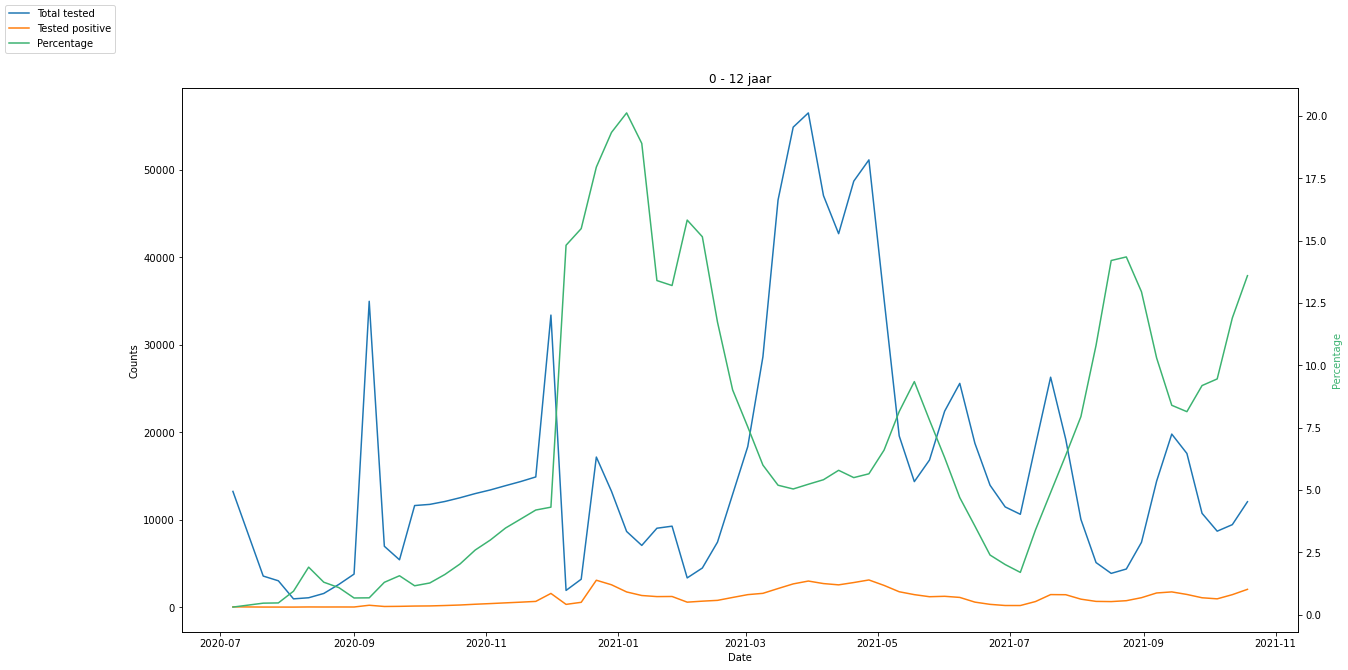

In [14]:
#%matplotlib widget
# These lines generate the data to be plotted
kinderen = data[data.loc[:,'Agerange'] == '0 - 12']
kinderen = kinderen.groupby(by=kinderen.index).mean()
x = kinderen.index
y = kinderen['Total tested']
y1 = kinderen['Tested positive']
y2 = kinderen['Percentage']

fig, ax1 = plt.subplots(figsize=(20,10)) # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(x = x, y = y, ax = ax1, estimator='max') # plots the first set of data, and sets it to ax1. 
#sns.lineplot(x = x, y = y, ax = ax1, estimator=None, style=True, dashes=[(2, 2)], color='lightblue') # plots the first set of data, and sets it to ax1. 
sns.lineplot(x = x, y = y1, ax = ax1, estimator='max') # plots the first set of data, and sets it to ax1. 
sns.lineplot(x = x, y = y2, ax = ax2, color='mediumseagreen', estimator='max') # plots the first set of data, and sets it to ax1. 

# these lines add the annotations for the plot. 
ax1.set_xlabel('Date')
ax1.set_ylabel('Counts')
ax2.set_ylabel('Percentage', color='mediumseagreen')

ax1.set_title(label='0 - 12 jaar')
fig.legend(labels=['Total tested', 'Tested positive', 'Percentage'], loc='upper left')
plt.show(); # shows the plot.

Text(0.5, 1.0, 'Aantal testen')

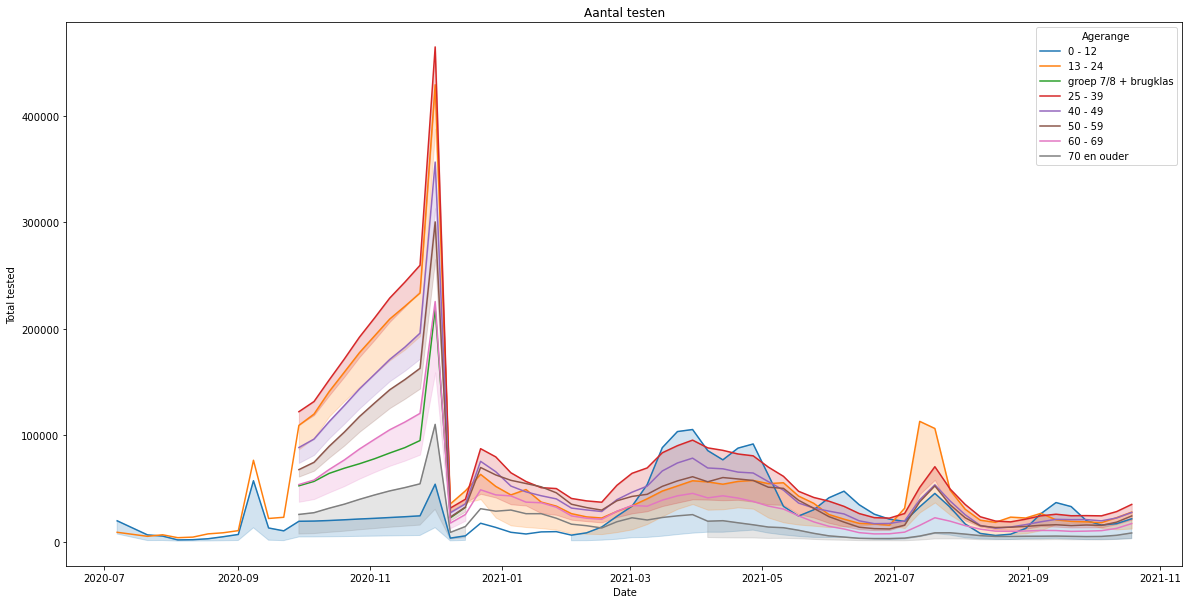

In [15]:
#%matplotlib widget
sns.lineplot(data=data, x="Date", y="Total tested", hue="Agerange", estimator='max').set_title('Aantal testen')

Text(0.5, 1.0, 'Aantal positieve testen')

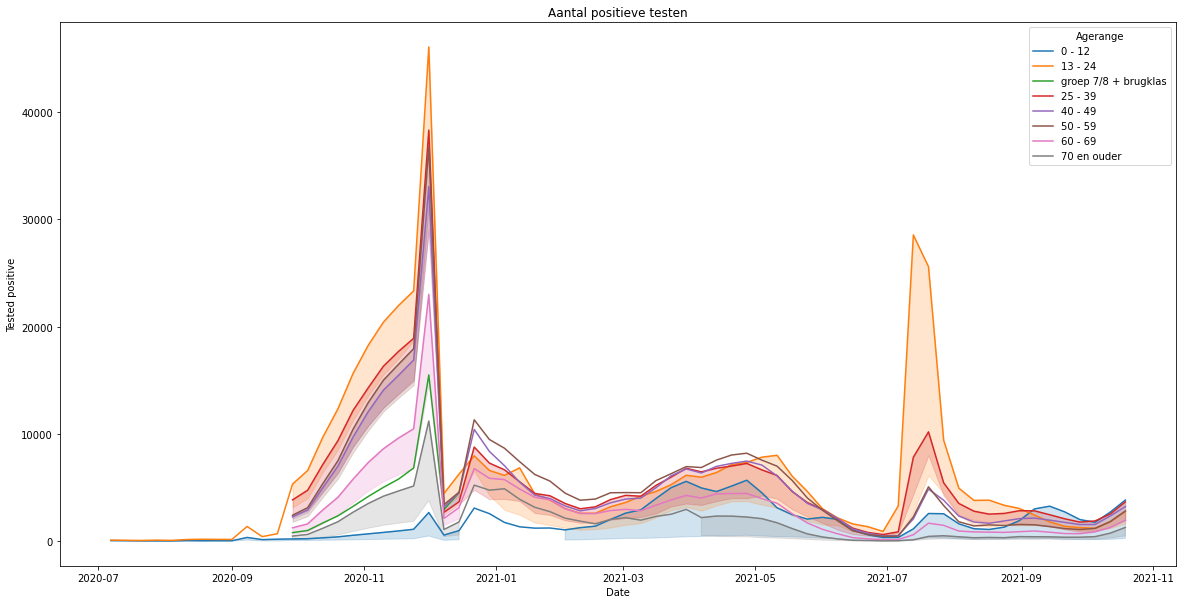

In [16]:
#%matplotlib widget
sns.lineplot(data=data, x="Date", y="Tested positive", hue="Agerange", estimator='max').set_title('Aantal positieve testen')

Text(0.5, 1.0, 'Aantal testen')

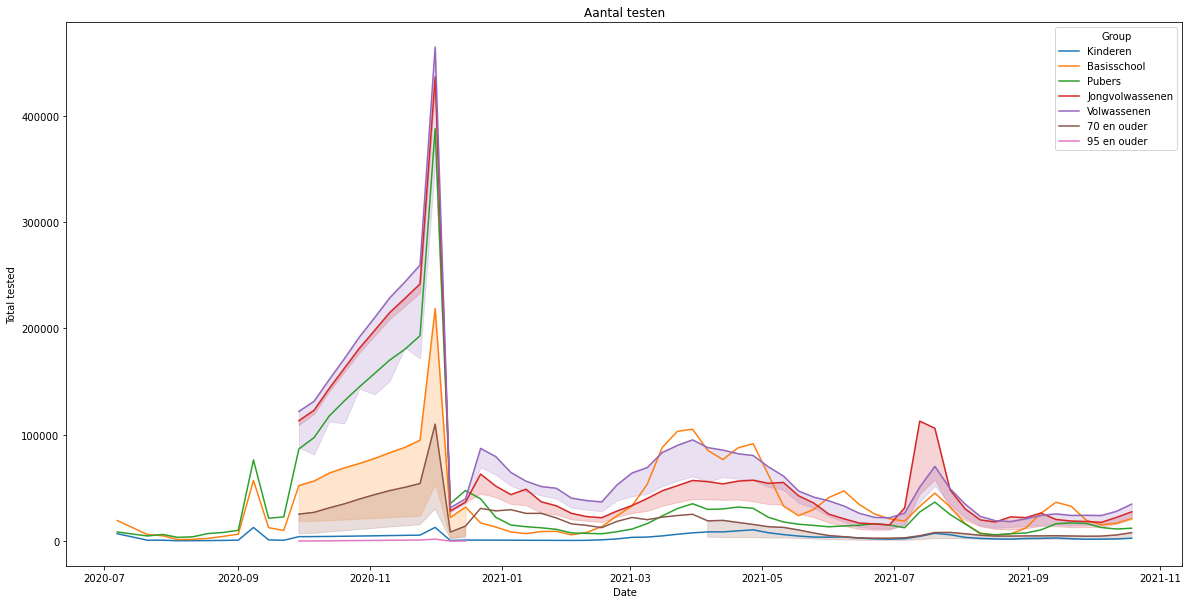

In [17]:
#%matplotlib widget
sns.lineplot(data=data, x="Date", y="Total tested", hue="Group", estimator='max').set_title('Aantal testen')

Text(0.5, 1.0, 'Aantal positieve testen')

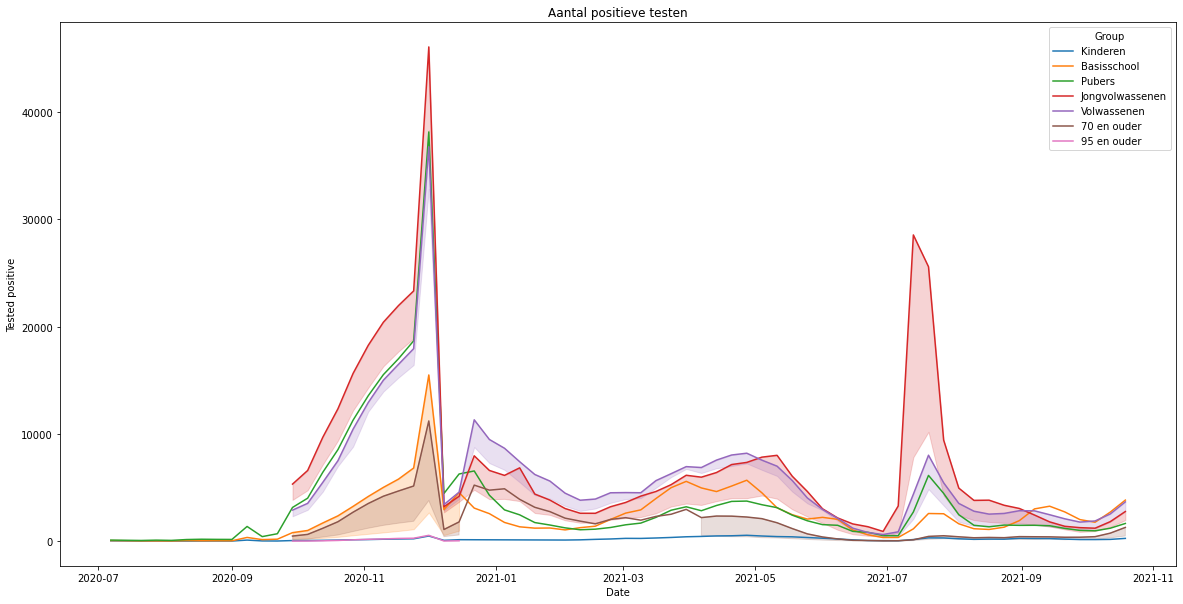

In [18]:
#%matplotlib widget
sns.lineplot(data=data, x="Date", y="Tested positive", hue="Group", estimator='max').set_title('Aantal positieve testen')

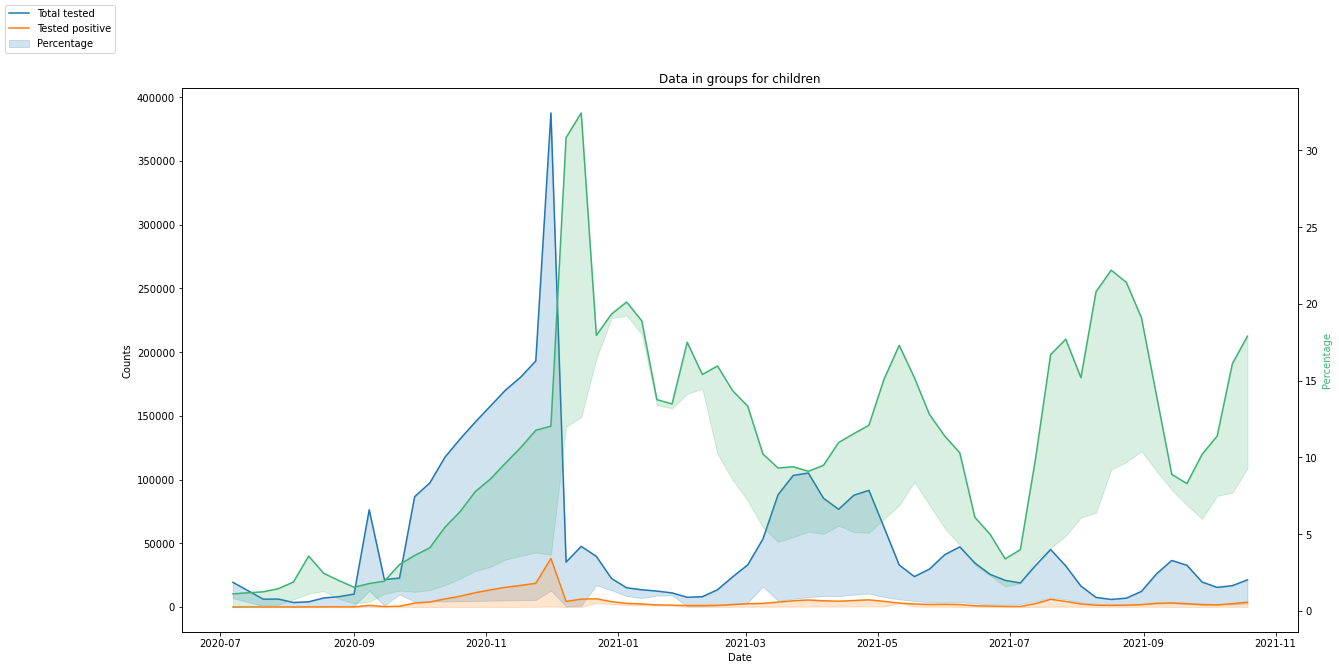

In [19]:
#%matplotlib widget
import seaborn as sns # Calls in seaborn

# These lines generate the data to be plotted
grouped = data[(data['Group'] == 'Kinderen') | (data['Group'] == 'Basisschool') | (data['Group'] == 'Pubers') | (data['Group'] == '4 - 11')].groupby(by=['Date','Group']).sum()
grouped.reset_index(level='Group', inplace=True)
grouped['Percantage'] = grouped['Tested positive'] / grouped['Total tested'] * 100

x = grouped.index
y = grouped['Total tested']
y1 = grouped['Tested positive']
y2 = grouped['Percentage']

fig, ax1 = plt.subplots(figsize=(20,10)) # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(x = x, y = y, ax = ax1, estimator='max') # plots the first set of data, and sets it to ax1. 
#sns.lineplot(x = x, y = y, ax = ax1, estimator=None, style=True, dashes=[(2, 2)], color='lightblue') # plots the first set of data, and sets it to ax1. 
sns.lineplot(x = x, y = y1, ax = ax1, estimator='max') # plots the first set of data, and sets it to ax1. 
sns.lineplot(x = x, y = y2, ax = ax2, color='mediumseagreen', estimator='max') # plots the first set of data, and sets it to ax1. 

# these lines add the annotations for the plot. 
ax1.set_xlabel('Date')
ax1.set_ylabel('Counts')
ax2.set_ylabel('Percentage', color='mediumseagreen')

ax1.set_title(label='Data in groups for children')
fig.legend(labels=['Total tested', 'Tested positive', 'Percentage'], loc='upper left')
plt.show(); # shows the plot.

## What can be used from the reports

### Chapter 4 agegroups
Reported, Hospitalised, Deceased agegroups

cumulatief